<a href="" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Activity Classifier

In this notebook, we build a dense neural net to classify PE activity. We use demographic data as well as the ecceleration data

#### Load dependencies

In [1]:
import tensorflow
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv1D, Concatenate , Input
from tensorflow.keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D, MaxPool1D,AveragePooling1D
from tensorflow.keras.callbacks import ModelCheckpoint 
from sklearn.metrics import confusion_matrix
import os 
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer, StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

In [2]:
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())
import tensorflow as tf
print("# GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tensorflow.__version__

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 18011303305847983487
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 13129224485127288950
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4022219571
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15677442493134263503
physical_device_desc: "device: 0, name: Quadro P2000, pci bus id: 0000:01:00.0, compute capability: 6.1"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 8385334598621825105
physical_device_desc: "device: XLA_GPU device"
]
# GPUs Available:  1


'2.3.1'

#### Set hyperparameters

In [3]:
# output directory name:
output_dir = 'model_output/demographic-cnn-large'
input_dir =  'Z:/Research/dfuller/Walkabilly/studies/smarphone_accel/data/Ethica_Jaeger_Merged/pocket/'
input_file_name = 'pocket-NN-data.npz'

# from the data preparation section we have:
window_size_second = 3
frequency = 30
lenght_of_each_seq = window_size_second * frequency



n_dense_2= 512
n_dense_1= 512
n_conv_3= 256
n_conv_2= 512
n_conv_1= 512
maxpooling_pool_size= 2
k_conv_3= 2
k_conv_2= 2
k_conv_1= 2
dropout_2= 0.2
dropout_1= 0.2
avepooling_pool_size= 2
activation_dense = 'relu'
activation_conv = 'relu'




# training:
epochs = 60
batch_size = 256


#### Load data

##### For this notebook we use the acceleration data gathered from the pocket location. It was prepared in the DataPrep-Deep notebook

In [4]:
# read the raw file and get the keys:
raw_data = np.load(file=input_dir+input_file_name,allow_pickle=True)
for k in raw_data.keys():
    print(k)

acceleration_data
metadata
labels


In [5]:
# import the data

accel_array = raw_data['acceleration_data']
meta_array = raw_data['metadata']
labels_array = raw_data['labels']
accel_input_shape = list(accel_array.shape)
meta_input_shape = list(meta_array.shape)


#### Preprocess data

### Data preparation 
1- Convert the  labels to integer.
In the raw data format of the labels is String and there are 6 classes. 'Lying', 'Sitting', 'Self Pace walk', 'Running 3 METs',
       'Running 5 METs', 'Running 7 METs' <br>

2- Standardize the demographic data
3- Split and shuffle



In [6]:
lb = LabelBinarizer()
y = lb.fit_transform(labels_array)
n_class = len(lb.classes_)
class_list = lb.classes_

In [7]:
sc = StandardScaler()
meta_array = sc.fit_transform(meta_array)

In [8]:
X_train_index, X_valid_index, y_train, y_valid = train_test_split(
     (np.arange(len(accel_array))), y, test_size=0.1, random_state=65)
X_accel_train = accel_array[X_train_index]
X_accel_valid = accel_array[X_valid_index]
X_meta_train = meta_array[X_train_index]
X_meta_valid = meta_array[X_valid_index]





#### Design neural network architecture using functional API

In [9]:
accel_input = Input(shape=accel_input_shape[1:])
meta_input = Input(shape=meta_input_shape[1:])
x = Conv1D(n_conv_1, k_conv_1, activation=activation_conv)(accel_input)
x = MaxPool1D(pool_size = maxpooling_pool_size)(x)
x = Conv1D(n_conv_2, k_conv_2, activation=activation_conv)(x)
x = AveragePooling1D(pool_size = avepooling_pool_size)(x)
x = Conv1D(n_conv_2, k_conv_2, activation=activation_conv)(x)
x = GlobalAveragePooling1D()(x)
meta_input_x = Flatten()(meta_input)
x = Concatenate()([x,meta_input_x])

x = Dense(n_dense_1, activation=activation_dense)(x)
x = Dropout(dropout_1)(x)
x = Dense(n_dense_2, activation=activation_dense)(x)
x = Dropout(dropout_2)(x)



output = Dense(n_class, activation='softmax')(x)
     
model = Model(inputs=[accel_input, meta_input], outputs=output, name='biInput')
model.summary()

Model: "biInput"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 90, 3)]      0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 89, 512)      3584        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 44, 512)      0           conv1d[0][0]                     
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 43, 512)      524800      max_pooling1d[0][0]              
____________________________________________________________________________________________

#### Configure model

In [10]:
model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])

In [11]:
modelcheckpoint = ModelCheckpoint(filepath=output_dir+
                                  "/weights.{epoch:02d}.hdf5")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

#### Train!

In [12]:
model.fit(x=[X_accel_train, X_meta_train], y=y_train, 
         batch_size=batch_size, epochs=epochs, verbose=1, 
         validation_data=([X_accel_valid, X_meta_valid], y_valid), 
          callbacks=[modelcheckpoint])


Epoch 1/60
228/228 [==============================] - 12s 52ms/step - loss: 0.9918 - accuracy: 0.5957 - val_loss: 0.6488 - val_accuracy: 0.7573
Epoch 2/60
228/228 [==============================] - 11s 48ms/step - loss: 0.5423 - accuracy: 0.7960 - val_loss: 0.4029 - val_accuracy: 0.8459
Epoch 3/60
228/228 [==============================] - 11s 48ms/step - loss: 0.3771 - accuracy: 0.8653 - val_loss: 0.2836 - val_accuracy: 0.9033
Epoch 4/60
228/228 [==============================] - 11s 48ms/step - loss: 0.2796 - accuracy: 0.9062 - val_loss: 0.2144 - val_accuracy: 0.9302
Epoch 5/60
228/228 [==============================] - 11s 48ms/step - loss: 0.2228 - accuracy: 0.9279 - val_loss: 0.2560 - val_accuracy: 0.9186
Epoch 6/60
228/228 [==============================] - 11s 48ms/step - loss: 0.1894 - accuracy: 0.9392 - val_loss: 0.2062 - val_accuracy: 0.9341
Epoch 7/60
228/228 [==============================] - 11s 48ms/step - loss: 0.1890 - accuracy: 0.9404 - val_loss: 0.2293 - val_accuracy:

228/228 [==============================] - 11s 48ms/step - loss: 0.0320 - accuracy: 0.9893 - val_loss: 0.1206 - val_accuracy: 0.9747
Epoch 58/60
228/228 [==============================] - 11s 48ms/step - loss: 0.0322 - accuracy: 0.9881 - val_loss: 0.1216 - val_accuracy: 0.9739
Epoch 59/60
228/228 [==============================] - 11s 48ms/step - loss: 0.0340 - accuracy: 0.9885 - val_loss: 0.1194 - val_accuracy: 0.9710
Epoch 60/60
228/228 [==============================] - 11s 48ms/step - loss: 0.0303 - accuracy: 0.9893 - val_loss: 0.1178 - val_accuracy: 0.9736


In [13]:
# os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'


#### Evaluate

In [29]:
model.load_weights(output_dir+"/weights.42.hdf5")

In [30]:
y_hat = model.predict([X_accel_valid, X_meta_valid])

In [31]:
len(y_hat)

6476

In [32]:
y_hat[0]

array([1.8851224e-05, 3.3848388e-13, 5.5419131e-11, 5.7640790e-13,
       4.8155822e-09, 9.9998116e-01], dtype=float32)

In [33]:
y_valid[0]

array([0, 0, 0, 0, 0, 1])

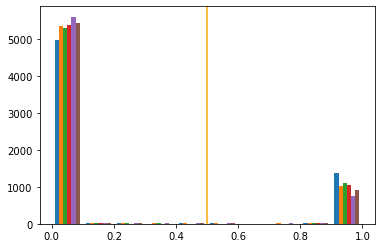

In [34]:
plt.hist(y_hat)
_ = plt.axvline(x=0.5, color='orange')

In [35]:
pct_auc = roc_auc_score(y_valid, y_hat)*100.0

In [36]:
"{:0.2f}".format(pct_auc)

'99.86'

In [37]:
float_y_hat = []
for y in y_hat:
    float_y_hat.append(y[0])

In [38]:
ydf = pd.DataFrame(list(zip(float_y_hat, y_valid)), columns=['y_hat', 'y'])

In [39]:
ydf.head(10)


,y_hat,y
0,1.885122e-05,"[0, 0, 0, 0, 0, 1]"
1,1.683720e-26,"[0, 0, 1, 0, 0, 0]"
2,5.339741e-10,"[0, 1, 0, 0, 0, 0]"
3,1.000000e+00,"[1, 0, 0, 0, 0, 0]"
4,1.145929e-11,"[0, 1, 0, 0, 0, 0]"
5,8.092278e-04,"[0, 0, 0, 0, 0, 1]"
6,1.337827e-21,"[0, 0, 0, 1, 0, 0]"
7,4.752539e-04,"[0, 1, 0, 0, 0, 0]"
8,1.000000e+00,"[1, 0, 0, 0, 0, 0]"
9,6.180746e-04,"[0, 1, 0, 0, 0, 0]"


In [40]:
# cf_matrix = confusion_matrix(y_valid, y_hat)
# print(cf_matrix) # doesn't work coz we have probability not class
y_hat

array([[1.8851224e-05, 3.3848388e-13, 5.5419131e-11, 5.7640790e-13,
        4.8155822e-09, 9.9998116e-01],
       [1.6837202e-26, 8.7345854e-21, 1.0000000e+00, 2.0770980e-16,
        3.2389475e-35, 2.9405074e-16],
       [5.3397414e-10, 1.0000000e+00, 1.7058223e-09, 2.5999684e-12,
        6.8464447e-14, 8.6110251e-12],
       ...,
       [5.3163373e-11, 2.2945498e-07, 8.7621925e-07, 3.2983019e-07,
        2.3134624e-12, 9.9999857e-01],
       [9.9999607e-01, 5.3380932e-13, 4.2728130e-11, 1.8599009e-06,
        1.5917799e-12, 2.0692473e-06],
       [9.9999678e-01, 2.9979269e-13, 2.2979308e-11, 1.6086750e-06,
        1.1920547e-12, 1.7221028e-06]], dtype=float32)

In [41]:
# convert probability to class
y_pred_class = np.argmax(y_hat, axis=1)
y_class = np.argmax(y_valid, axis = 1)

In [42]:
from sklearn.metrics import  accuracy_score as score
# y_pred_classes = y_hat.round()
# print(y_valid[0], y_hat[0], y_pred_classes[0])
# acc = score(y_valid, y_pred_classes) * 100
# acc

y_pred_classes = y_hat.round()
acc = score(y_valid, y_pred_classes) * 100
"{:0.2f}".format(acc)

'97.41'

array([[1394,    8,    2,    3,    7,   13],
       [   2, 1036,    9,    0,   12,    5],
       [   2,    4, 1097,    6,    3,    2],
       [   3,    2,   16, 1060,    4,    2],
       [   4,   11,    4,    1,  784,    1],
       [  16,    1,    6,    0,   10,  946]], dtype=int64)

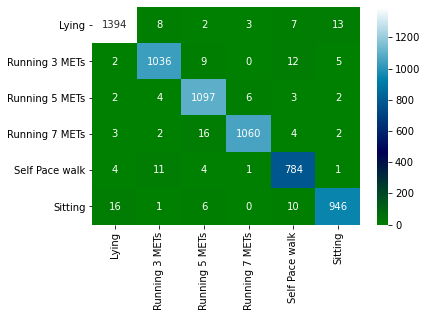

In [43]:
cf_matrix = confusion_matrix(y_class, y_pred_class, labels=range(6))
import seaborn as sns
sns.heatmap(cf_matrix, annot=True, fmt = '1', xticklabels=class_list, yticklabels=class_list, cmap='ocean')
cf_matrix

Reorder columns and rows and plot a pretty confucion matrix, thanks to [Wagner Cipriano
](https://github.com/wcipriano/pretty-print-confusion-matrix)

In [96]:
confusion_matrix_df = pd.DataFrame(cf_matrix, index=class_list, columns=class_list)
confusion_matrix_df = confusion_matrix_df[['Lying','Sitting', 'Self Pace walk', 'Running 3 METs','Running 5 METs', 'Running 7 METs']]
confusion_matrix_df = confusion_matrix_df.reindex(['Lying', 'Sitting', 'Self Pace walk', 'Running 3 METs','Running 5 METs', 'Running 7 METs'])

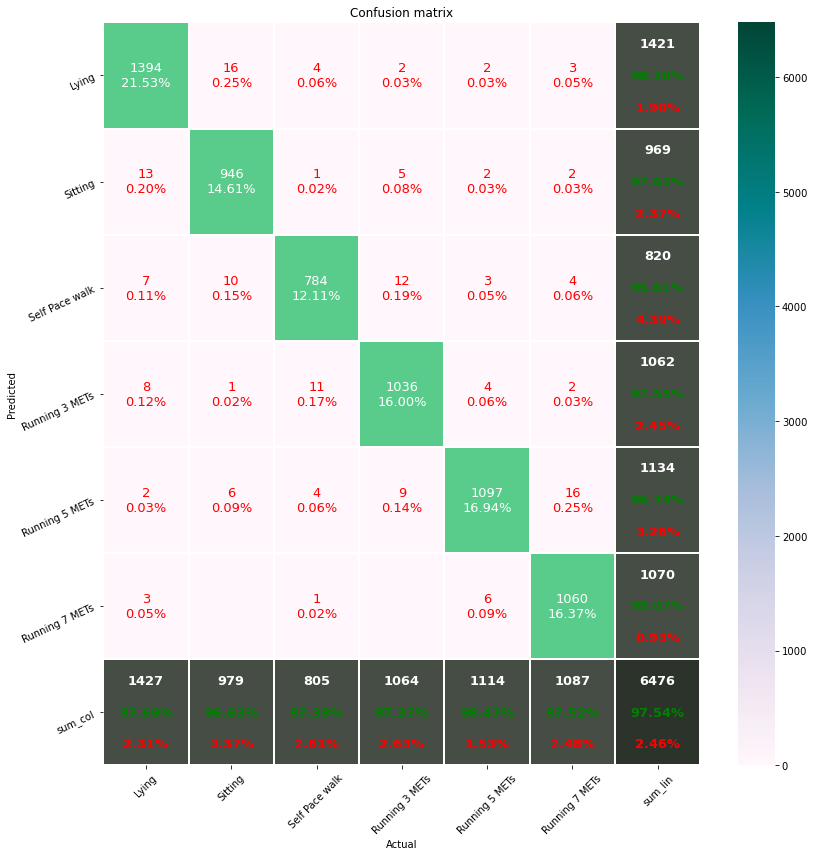

In [99]:
import prettyconfusion as pf
pf.pretty_plot_confusion_matrix(confusion_matrix_df,cmap='PuBuGn', cbar='oranges'
                                ,fz = 13, lw=1, figsize=[12,12])